In [139]:
# Binance API information
API_KEY = ""
SECRET_KEY = ""


In [42]:
import requests
import json
import pandas as pd
import datetime as dt

In [190]:
import requests
import time

def fetch_binance_historical_data(symbol, interval, start_time, end_time):
    """
    Fetches historical k-line data from Binance API for a given symbol, interval, start time, and end time.
    
    :param symbol: str, trading pair symbol (e.g., 'BTCUSDT' for Bitcoin/USDT)
    :param interval: str, timeframe for the historical data (e.g., '1d' for daily)
    :param start_time: int, start timestamp in milliseconds
    :param end_time: int, end timestamp in milliseconds
    :return: list of dictionaries, historical k-line data
    """
    # Define API endpoint
    endpoint = 'https://api.binance.com/api/v3/klines'
    
    # Initialize empty list to store historical data
    historical_data = []
    
    # Loop until end time is reached
    while start_time < end_time:
        # Calculate remaining time until end time or maximum allowed timeframe (500 data points)

        if interval[-1] == 'h':
            interval_size = (int(interval[0]) * 60) - 1
        else:
            interval_size = int(interval[:-1])
        
        remaining_time = min(end_time - start_time, 500 * interval_size * 60 * 1000)
        
        # Define API parameters for current request
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': start_time + remaining_time,
            'limit': 500,
        }
        
        # Send API request and parse response
        response = requests.get(endpoint, params=params)
        data = response.json()

        # display(len(data)) 
        
        # Append fetched data to historical_data list
        historical_data.extend(data)
        
        # Update start time for next request
        start_time += remaining_time + (int(interval[:-1]) * 60 * 1000)
        
        # Add delay to avoid hitting API rate limits (optional)
        time.sleep(1)
    
    return historical_data


In [218]:
# hist_data = fetch_binance_historical_data(symbol = 'AXSUSDT',
#                                           interval = '1h',
#                                           start_time = int(dt.datetime(2023,3,1).timestamp()*1000),
#                                           end_time = int(dt.datetime(2023,4,13).timestamp()*1000))

hist_data = fetch_binance_historical_data(symbol = 'AXSUSDT',
                                          interval = '1h',
                                          start_time = int(dt.datetime(2023,3,1).timestamp()*1000),
                                          end_time = int(dt.datetime(2023,5,6).timestamp()*1000))

In [219]:
len(hist_data)

1584

In [220]:
data = pd.DataFrame(hist_data)
#format columns name
data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
data=data.astype(float)
data.tail()

,datetime,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
2023-05-05 20:00:00,1.683288e+12,7.62,7.64,7.47,7.55,44559.89,1.683292e+12,336678.8271,1578.0,14863.18,112301.7937,0.0
2023-05-05 21:00:00,1.683292e+12,7.55,7.62,7.53,7.61,16389.72,1.683295e+12,124179.4459,484.0,9290.71,70441.7859,0.0
2023-05-05 22:00:00,1.683295e+12,7.62,7.69,7.61,7.68,36715.20,1.683299e+12,280721.0257,975.0,20826.63,159304.9533,0.0
2023-05-05 23:00:00,1.683299e+12,7.68,7.73,7.67,7.71,30138.36,1.683302e+12,232078.7388,757.0,20587.24,158573.0048,0.0
2023-05-06 00:00:00,1.683302e+12,7.72,7.81,7.71,7.77,70995.83,1.683306e+12,551780.6399,1755.0,44215.81,343750.4254,0.0


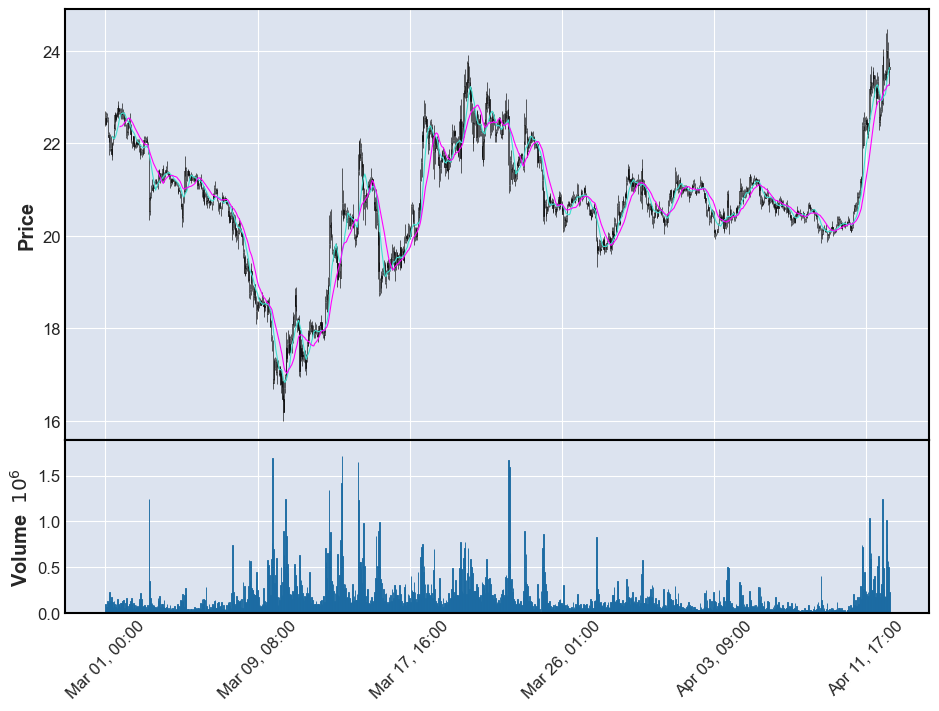

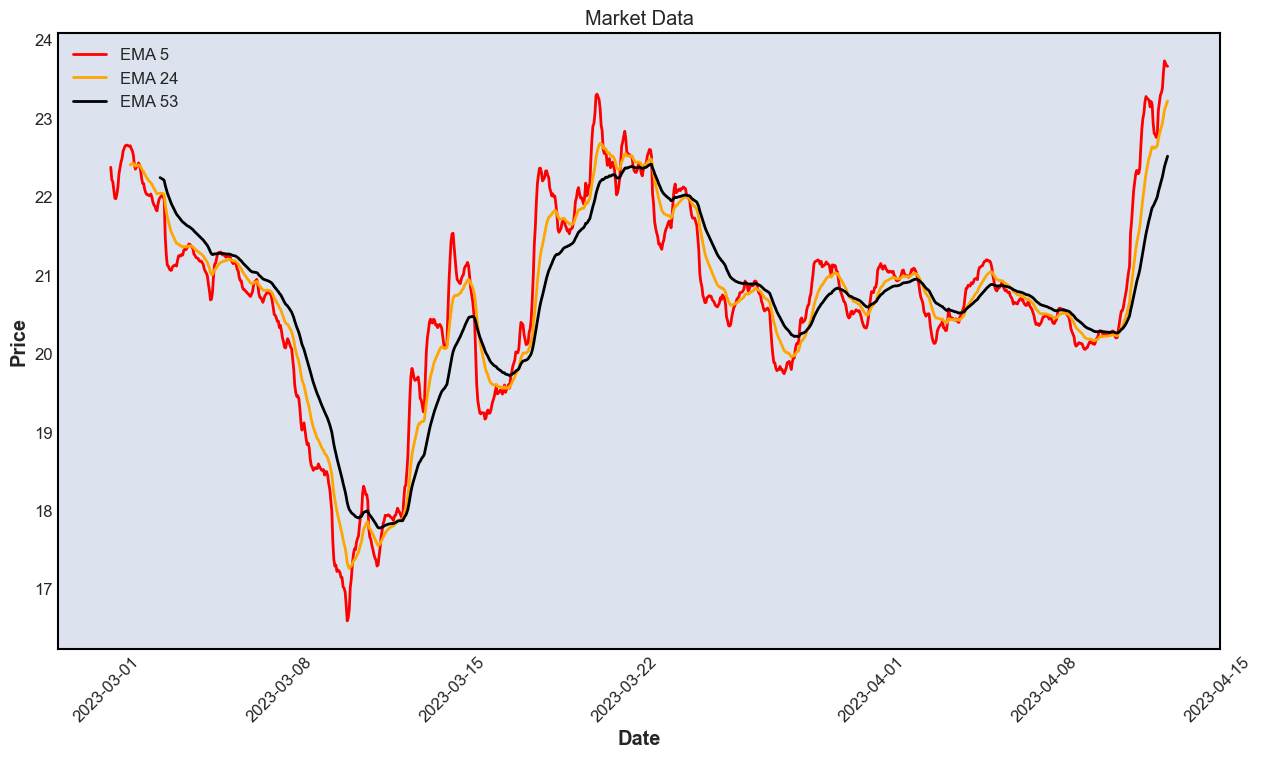

In [72]:
#plot the outcome

import pandas as pd
import matplotlib.pyplot as plt
# from mpl_finance import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mdates
from talib import EMA

# Load OHLCV data into a Pandas DataFrame
# df = pd.read_csv('ohlc_data.csv', parse_dates=True, index_col=0)
df = data

# Calculate exponential moving averages
df['EMA_5'] = EMA(df['close'], timeperiod=5)
df['EMA_24'] = EMA(df['close'], timeperiod=24)
df['EMA_53'] = EMA(df['close'], timeperiod=53)

# Prepare the data for plotting
# df_ohlc = df[['open', 'high', 'low', 'close']].resample('1D').ohlc()
# df_volume = df['volume'].resample('1D').sum()
# df_ohlc.reset_index(inplace=True)
# # df_ohlc['datetime'] = df_ohlc['datetime'].map(mdates.date2num)

# Create the plot
# fig, ax = plt.subplots()
# candlestick_ohlc(ax, df_ohlc.values, width=0.6, colorup='g', colordown='r', alpha=1.0)
mpf.plot(df,type='candle',volume=True,mav=(10,20),figscale=1.5,warn_too_much_data=2000)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.figure(figsize=(15,8))

plt.xticks(rotation=45)
plt.title('Market Data')
plt.ylabel('Price')
plt.xlabel('Date')

# Add EMA lines
plt.plot(df.index, df['EMA_5'], label='EMA 5', color='red')
plt.plot(df.index, df['EMA_24'], label='EMA 24', color='orange')
plt.plot(df.index, df['EMA_53'], label='EMA 53', color='black')

# Customize the plot
plt.legend()
plt.grid()
plt.show()


In [14]:
from scipy.optimize import differential_evolution
from skopt import gp_minimize

# Define objective function
def objective(params):
    fast_length, slow_length, signal_length = params
    
    # Define strategy
    class MACDStrategy(bt.Strategy):
        params = (
            ('starting_cash', 10000),
        )
    
        def __init__(self):
            self.macd = bt.indicators.MACD(
                period_me1=int(fast_length),
                period_me2=int(slow_length),
                period_signal=int(signal_length)
            )
            self.stop_loss_pct = 0.02  # 2% stop loss threshold
    
        def next(self):
            if not self.position:
                if self.macd.lines.macd[0] > self.macd.lines.signal[0]:
                    # Buy signal
                    self.buy(size=self.params.starting_cash / self.data.close[0])
    
            else:
                if self.macd.lines.macd[0] < self.macd.lines.signal[0] or \
                        self.data.close[0] < self.position.price * (1 - self.stop_loss_pct):
                    # Sell signal or stop loss triggered
                    self.sell(size=self.position.size)
    
    cerebro = bt.Cerebro()
    
    # Add data to cerebro
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    
    # Add strategy to cerebro
    cerebro.addstrategy(MACDStrategy)
    
    # Set starting capital
    cerebro.broker.setcash(10000)
    
    # Run backtest
    results = cerebro.run()
    profit = results[0].broker.getvalue() - 10000

    # print(params)
    # print(profit)
    
    return -profit  # Objective is to maximize profit, so we negate it for minimization


# Define parameter bounds
bounds = [(5, 20), (20, 40), (5, 15)]  # bounds for fast length, slow length, signal length

# Initial parameter values
# x0 = np.array([12, 26, 9])  # initial values for fast length, slow length, signal length
x0 = np.array([6, 30, 5])  # initial values for fast length, slow length, signal length

# Define integer constraints
# integers = [0, 1, 2]

# Define differential evolution solver
solver = 'differential_evolution'

# # Run optimization
# result = differential_evolution(objective, bounds, strategy=solver, init='random', mutation=(0.5, 1), 
#                                 recombination=0.7, seed=0, tol=1e-6, atol=1e-8, polish=False, 
#                                 maxiter=100, popsize=15, updating='deferred', workers=1, constraints=integers)

# # Run optimization
# result = differential_evolution(objective, bounds, strategy='best1bin', init='random', mutation=(0.5, 1), 
#                                 recombination=0.7, seed=0, tol=1e-6, atol=1e-8, polish=False, 
#                                 maxiter=100, popsize=15, updating='deferred', workers=1, constraints=integers)

# Define custom constraint handler
def is_integer(x):
    """Check if x is an integer."""
    return np.equal(np.mod(x, 1), 0)

def constraint_handler(x):
    """Enforce integer constraints."""
    return np.array([x[0], x[1], x[2]]) - np.array([is_integer(x[0]), is_integer(x[1]), is_integer(x[2])])

# Run optimization
result = differential_evolution(objective, bounds, strategy='best1bin', init='random', mutation=(0.5, 1), 
                                recombination=0.7, seed=0, tol=1e-6, atol=1e-8, polish=False, 
                                maxiter=100, popsize=15, updating='deferred', workers=1)

# Extract optim

# Minimize the objective function
# result = minimize(objective, x0, bounds=bounds, options={'integer_tol': 1e-9})
# , method='trust-constr'
# try Bayesian Optimization

# Extract optimal parameter values and profit
optimal_fast_length, optimal_slow_length, optimal_signal_length = result.x
optimal_profit = -result.fun

# Print optimal parameter values and profit
print("Optimal MACD Fast Length:", int(optimal_fast_length))
print("Optimal MACD Slow Length:", int(optimal_slow_length))
print("Optimal MACD Signal Length:", int(optimal_signal_length))
print("Optimal Profit:", optimal_profit)

Optimal MACD Fast Length: 7
Optimal MACD Slow Length: 28
Optimal MACD Signal Length: 5
Optimal Profit: -62.19458018658406


In [44]:
from scipy.optimize import differential_evolution
from bayes_opt import BayesianOptimization

# Define objective function
# Define objective function for Bayesian optimization
def objective(fast_length, slow_length, signal_length):
    # Convert parameters to integer values
    fast_length = int(fast_length)
    slow_length = int(slow_length)
    signal_length = int(signal_length)
    # Define strategy
    class MACDStrategy(bt.Strategy):
        params = (
            ('starting_cash', 10000),
        )
    
        def __init__(self):
            self.macd = bt.indicators.MACD(
                period_me1=int(fast_length),
                period_me2=int(slow_length),
                period_signal=int(signal_length)
            )
            self.stop_loss_pct = 0.02  # 2% stop loss threshold
    
        def next(self):
            if not self.position:
                if self.macd.lines.macd[0] > self.macd.lines.signal[0]:
                    # Buy signal
                    self.buy(size=self.params.starting_cash / self.data.close[0])
    
            else:
                if self.macd.lines.macd[0] < self.macd.lines.signal[0]:
                # or \
                        # self.data.close[0] < self.position.price * (1 - self.stop_loss_pct):
                    # Sell signal or stop loss triggered
                    self.sell(size=self.position.size)
    
    cerebro = bt.Cerebro()
    
    # Add data to cerebro
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    
    # Add strategy to cerebro
    cerebro.addstrategy(MACDStrategy)
    
    # Set starting capital
    cerebro.broker.setcash(10000)
    
    # Run backtest
    results = cerebro.run()
    profit = results[0].broker.getvalue() - 10000

    # print(params)
    # print(profit)
    
    return profit  # Objective is to maximize profit
# , so we negate it for minimization



# Define parameter bounds for Bayesian optimization
bounds = {
    'fast_length': (5, 30),
    'slow_length': (10, 60),
    'signal_length': (5, 30)
}

# Perform Bayesian optimization
opt = BayesianOptimization(objective, bounds)
opt.maximize(n_iter=100, init_points=50)

# Extract optimal parameters
optimal_params = opt.max['params']
optimal_fast_length = int(optimal_params['fast_length'])
optimal_slow_length = int(optimal_params['slow_length'])
optimal_signal_length = int(optimal_params['signal_length'])
optimal_profit = float(opt.max['target'])

# Print optimal parameters
print('Optimal Parameters:')
print('Fast Length: {}'.format(optimal_fast_length))
print('Slow Length: {}'.format(optimal_slow_length))
print('Signal Length: {}'.format(optimal_signal_length))
print("Optimal Profit:", optimal_profit)


|   iter    |  target   | fast_l... | signal... | slow_l... |
-------------------------------------------------------------
| 1         | -103.7    | 28.55     | 12.62     | 25.32     |
| 2         | -599.8    | 8.468     | 8.869     | 50.1      |
| 3         | -354.5    | 17.93     | 26.35     | 47.51     |
| 4         | -354.5    | 27.61     | 23.22     | 39.32     |
| 5         | -178.1    | 5.001     | 23.09     | 38.02     |
| 6         | -187.3    | 17.34     | 9.673     | 51.03     |
| 7         | -173.2    | 14.33     | 15.07     | 46.49     |
| 8         | -259.1    | 25.2      | 13.23     | 48.87     |
| 9         | -164.8    | 25.62     | 6.92      | 10.02     |
| 10        | 0.0       | 10.04     | 10.49     | 10.41     |
| 11        | -178.5    | 28.47     | 18.32     | 17.24     |
| 12        | -685.1    | 15.64     | 16.13     | 17.95     |
| 13        | -146.0    | 16.28     | 17.31     | 55.61     |
| 14        | -146.0    | 28.29     | 9.119     | 57.96     |
| 15    